<a href="https://colab.research.google.com/github/Maryam-Afshari/thesis/blob/master/MLR_Lobith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking out the GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 14:31:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# checking out the memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Running MLR on Lobith station 

In [4]:
#!pip install hydroeval

In [5]:
# required libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import hydroeval as he
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# reading data
lobith = pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/lobith.csv',index_col=0)
q_lobith = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/data/q_lobith.csv",index_col=0)


### Feature engineering

In [8]:
# making lagged variables

# define the number of lags
TIME_STEPS = 55

#add the lagged variables for predictors to the dataframe
for i, var in enumerate(lobith[["et","p","t"]]):
  for step in range(0, TIME_STEPS - 1):
    lobith.insert(i*(TIME_STEPS) + 1,
                 f'{var}_lag_{TIME_STEPS - 1 - step}',
                 lobith[var].shift(TIME_STEPS - 1 - step))

#remove the first TIME_STEPS - 1 rows since they will contain NA values
lobith = lobith.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)
q_lobith = q_lobith.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


### Train-test split and defineing variables


In [9]:
# train-test split
len_ = int(0.75 * lobith.shape[0])

df_train = lobith[:len_]
df_test = lobith[len_:]

# x-train without lagged vars
X_train = df_train[["et","t","p"]]

# x-train with lagged vars
X_train_lagged = df_train.drop(columns = ["obs","datetime"], axis =1)
y_train = df_train.obs

# x-test without lagged vars
X_test = df_test[["et","t","p"]]

# x-test with lagged vars
X_test_lagged = df_test.drop(columns = ["obs","datetime"], axis =1)
y_test = df_test.obs

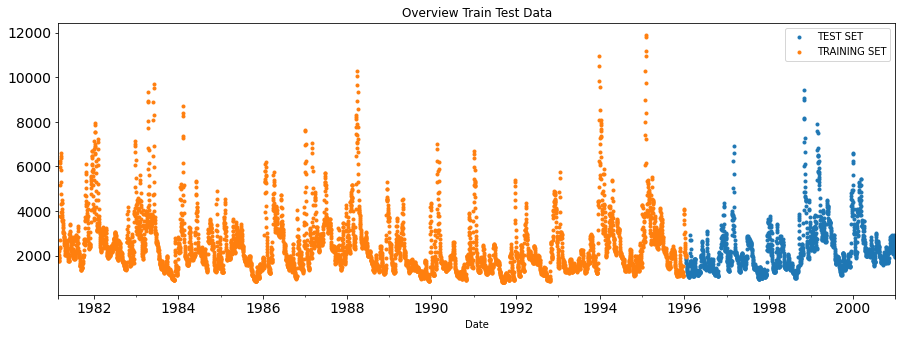

In [10]:
# ploting the train test period 

df_plot = lobith 
df_plot['datetime'] =  pd.to_datetime(df_plot['datetime'], infer_datetime_format=True)
df_plot = df_plot.set_index(['datetime'])
X_obs = df_plot.obs
#date = df_plot.datetime 
df_train_ = X_obs[:len_]
df_test_ = X_obs[len_:]

train_ = pd.DataFrame(df_train_)
test_ = pd.DataFrame(df_test_)

Overview_Train_Test_Data = test_ \
    .rename(columns={'obs': 'TEST SET'}) \
    .join(train_.rename(columns={'obs': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='.', fontsize = 14, xlabel = "Date")

plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/train-test-split.png")

In [11]:
# getting the names of features 
feature_names = X_train.columns

# getting the names of features of the  MLR_lag 
feature_names_lagged = X_train_lagged.columns

In [ ]:
# saving obs of y_test
#np.save("/content/drive/MyDrive/Thesis-Afshari/output/obs_MLR_55lag_lobith.npy", y_test, allow_pickle=True)

### Normalising data

In [12]:
# normalising perdictors 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# normalising perdictors for model with the lagged varibales
scaler_lagged = MinMaxScaler()
X_train_lagged = scaler_lagged.fit_transform(X_train_lagged)
X_test_lagged = scaler_lagged.transform(X_test_lagged)

### Model

In [13]:
# creating an object of LinearRegression class
lm = LinearRegression()

# fitting the training data
lm.fit(X_train,y_train)

# evaluating the model
lm.score(X_test, y_test)

0.036785669681463795

In [15]:
# getting the intercept of the MLR_S model 
lm.intercept_

3922.0147632589124

In [16]:
# getting the coefficients of the model
model_coefficients = lm.coef_

# reading the coefficients in a data frame
coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

    Coefficient value
et        1180.098080
t        -3262.007397
p         1142.703466


In [17]:
# creating an object of LinearRegression class
lm_lag = LinearRegression()

# fitting the training data for model with the lagged variables
lm_lag.fit(X_train_lagged,y_train)

# evaluating the model
lm_lag.score(X_test_lagged, y_test)

0.6723610120045485

In [ ]:
# getting the intercept of the MLR_lag model
lm_lag.intercept_

1271.963062863729

In [18]:
# getting the coefficients of the MLR_lag model 
model_coefficients_lagged = lm_lag.coef_

# reading the coefficients in a data frame
coefficients_lagged_df = pd.DataFrame(data = model_coefficients_lagged, 
                              index = feature_names_lagged, 
                              columns = ['Coefficient_value'])

# plot the coefficients

In [19]:
# getting the coefficients to plot 
df_et_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("et")]
df_t_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("t")]
df_p_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("p")]
df_negative_coe = coefficients_lagged_df[coefficients_lagged_df.Coefficient_value < 0]

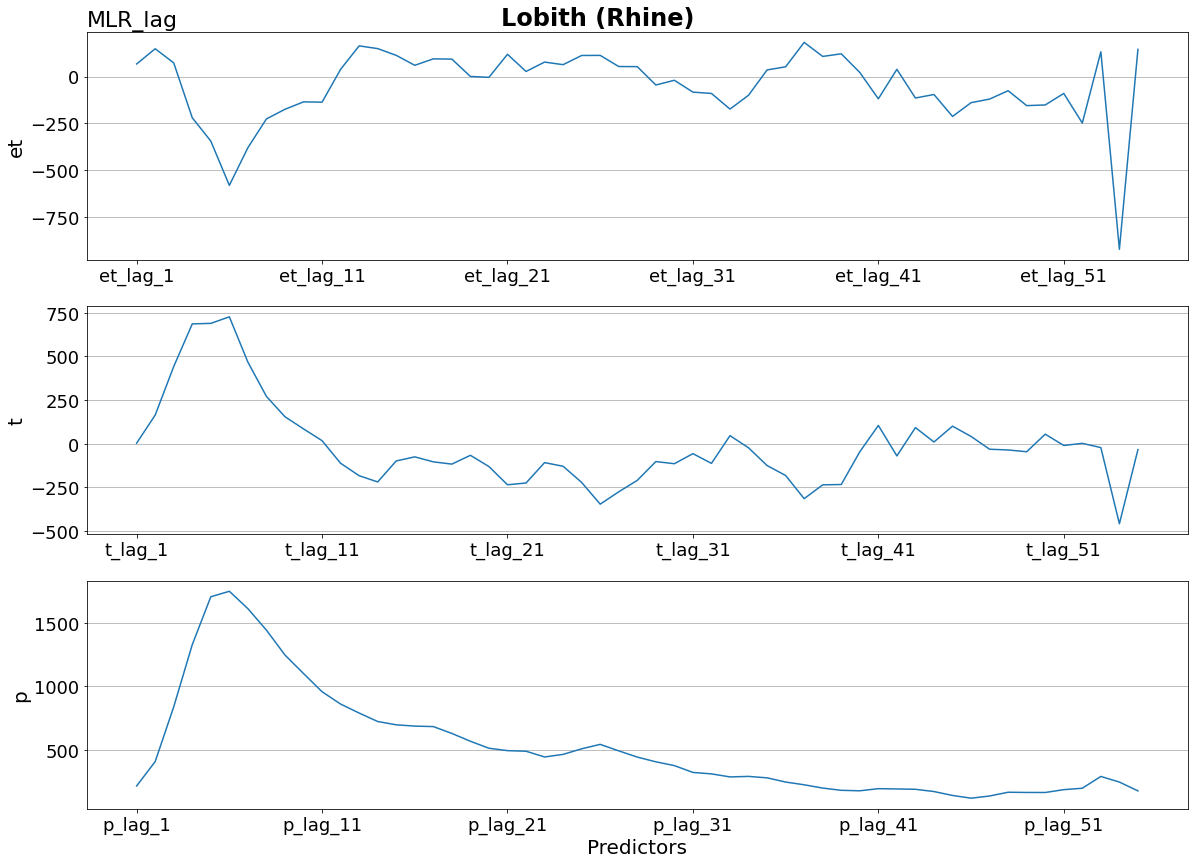

In [20]:
# pltoing the coefficients of the MLR_lag
plt.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(17, 20*2/(1+5**0.5)))  
df_et_coe.plot(ax = axes[0], legend=False, ylabel = "et", label = "Coefficient") 
df_t_coe.plot(ax = axes[1],  legend=False, ylabel = "t")
df_p_coe.plot(ax = axes[2],  legend=False, ylabel = "p", xlabel = "Predictors") 


# tweak the axes
axes[0].set_title("MLR_lag", loc ="left", fontsize =22)


for ax in axes:
  ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=18)
  ax.tick_params(axis='x', labelsize=18)
  
fig.suptitle('Lobith (Rhine)',fontweight ="bold")
fig.tight_layout()
# sav ethe fig
plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/coeficient_lobith.png") 
plt.show()

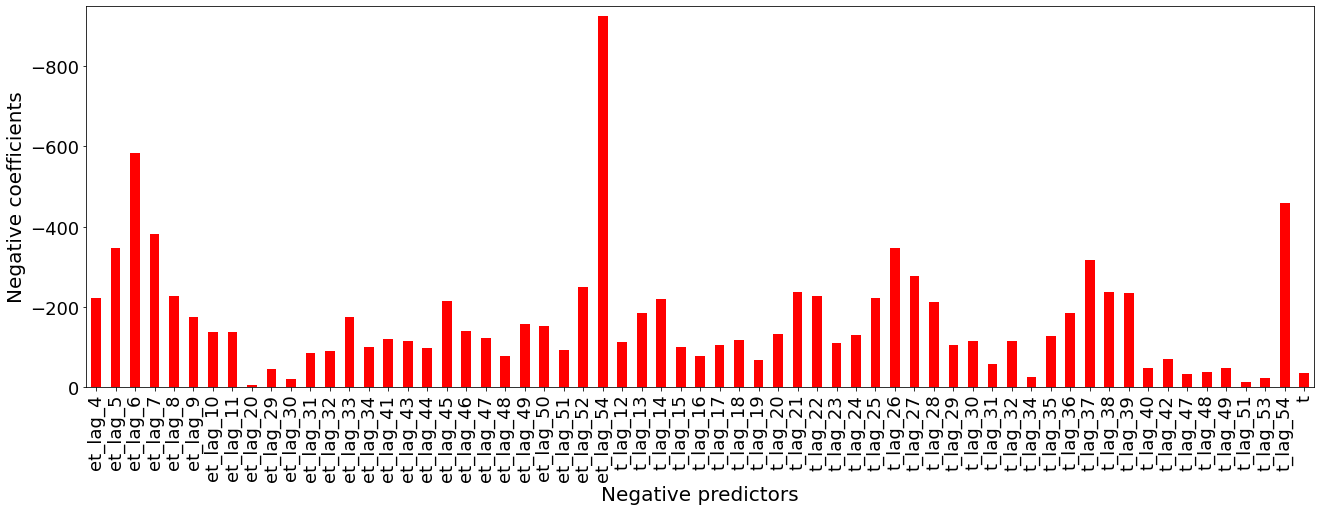

In [ ]:
# plot the negative laggs
df_negative_coe.plot(figsize=(22, 7), xlabel="Negative predictors", fontsize =18,  ylim = [0, -950],\
                            color = "r", linewidth=5,ylabel = "Negative coefficients", legend=False, kind ="bar" )
# save the fig
plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/coeficient_lobith_negative.png",bbox_inches='tight', dpi=150) 

### Evaluation

In [21]:
# evaluate pcr model using nse and kge
streamflow_pcr = q_lobith.pcr[len_:]
nse_pcr = he.evaluator(he.nse, streamflow_pcr,y_test)
kge_pcr, r_pcr, alpha_pcr, beta_pcr = he.evaluator(he.kge, streamflow_pcr, y_test)
print("The nse and kge of the PCR model are {:.2} and {:.2} respectively.".format(nse_pcr[0], kge_pcr[0]))

# predicting for model with only meteorological variables
y_pred =  lm.predict(X_test)

# predicting for model with meteorological variables + lagged variables
y_pred_lagged = lm_lag.predict(X_test_lagged)

# evaluate the prediction using nse and kge for model with only meteorological variables
nse = he.evaluator(he.nse, y_pred, y_test)
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)

# evaluate the prediction using nse and kge for model with meteorological variables + lagged variables
nse_lag = he.evaluator(he.nse, y_pred_lagged, y_test)
kge_lag, r_lag, alpha_lag, beta_lag = he.evaluator(he.kge, y_pred_lagged, y_test)
print("The nse and kge of the linear model are {:.2} and {:.2} respectively.".format(nse[0], kge[0]))
print("The nse and kge of the linear model including lagged variables are {:.2} and {:.2} respectively.".format(nse_lag[0], kge_lag[0]))

The nse and kge of the PCR model are 0.36 and 0.55 respectively.
The nse and kge of the linear model are 0.037 and -0.047 respectively.
The nse and kge of the linear model including lagged variables are 0.67 and 0.76 respectively.


In [ ]:
# saving y_preds
np.save("/content/drive/MyDrive/Thesis-Afshari/output/yhat_MLR_lobith.npy", y_pred, allow_pickle=True)
np.save("/content/drive/MyDrive/Thesis-Afshari/output/yaht_MLR_55lag_lobith.npy", y_pred_lagged , allow_pickle=True)